In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import time
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [4]:
with open('SVHN_train.pickle', 'rb') as f:
    tmp_save = pickle.load(f)
    train_dataset_56 = tmp_save['dataset']
    train_labels = tmp_save['labels']
    
valid_size = 2000
valid_dataset_56 = train_dataset_56[:valid_size]
valid_labels = train_labels[:valid_size]
train_dataset_56 = train_dataset_56[valid_size:]
train_labels = train_labels[valid_size:]

with open('SVHN_test.pickle', 'rb') as f:
    tmp_save = pickle.load(f)
    test_dataset_56 = tmp_save['dataset']
    test_labels = tmp_save['labels']
    
print('Training set', train_dataset_56.shape, train_labels.shape)
print('Validation set', valid_dataset_56.shape, valid_labels.shape)
print('Test set', test_dataset_56.shape, test_labels.shape)   

Training set (31402, 56, 56) (31402,)
Validation set (2000, 56, 56) (2000,)
Test set (13068, 56, 56) (13068,)


In [5]:
num_digits = 3
def trim_max_digits(dataset, labels, max_digits):
    keep = [i for i, label in enumerate(labels) if len(label) <= max_digits]
    return dataset[keep], labels[keep]

train_dataset_56, train_labels = trim_max_digits(train_dataset_56, train_labels, num_digits)
valid_dataset_56, valid_labels = trim_max_digits(valid_dataset_56, valid_labels, num_digits)
test_dataset_56, test_labels = trim_max_digits(test_dataset_56, test_labels, num_digits)
print('Training set', train_dataset_56.shape, train_labels.shape)
print('Validation set', valid_dataset_56.shape, valid_labels.shape)
print('Test set', test_dataset_56.shape, test_labels.shape) 

Training set (30041, 56, 56) (30041,)
Validation set (1917, 56, 56) (1917,)
Test set (12920, 56, 56) (12920,)


In [6]:
def show_image(img, label):
    print("Labels", label)
    print("Dtype", img.dtype)
    print("Shape", img.shape)
    print("Color range", np.min(img), np.max(img))
    if len(img.shape) > 2:
        plt.imshow(np.reshape(img, img.shape[:2]))
    else:
        plt.imshow(img)
    plt.show()
    
def show_images(imgs, labels, num=3):
    for i in range(num):
        num = np.random.randint(imgs.shape[0])
        show_image(imgs[num], labels[num])

In [7]:
num_labels = 11 # Add an extra character so we can deal with spaces
num_channels = 1 # grayscale

def reformat(dataset, labels):
    dataset_output = dataset.reshape(list(dataset.shape) + [1]).astype(np.float32)
    labels_output = np.array([np.array([(np.arange(num_labels) == l).astype(np.float32) 
                        for l in np.append(row, [num_labels-1] * (num_digits - len(row)), 0)])
              for row in labels])
    return dataset_output, labels_output

train_dataset_56, train_labels = reformat(train_dataset_56, train_labels)
valid_dataset_56, valid_labels = reformat(valid_dataset_56, valid_labels)
test_dataset_56, test_labels = reformat(test_dataset_56, test_labels)

print('Training set', train_dataset_56.shape, train_labels.shape)
print('Validation set', valid_dataset_56.shape, valid_labels.shape)
print('Test set', test_dataset_56.shape, test_labels.shape)

Training set (30041, 56, 56, 1) (30041, 3, 11)
Validation set (1917, 56, 56, 1) (1917, 3, 11)
Test set (12920, 56, 56, 1) (12920, 3, 11)


In [8]:
#Limit test set as it's killing the box
test_dataset_56 = test_dataset_56[:6000]
test_labels = test_labels[:6000]

# Create a pit sized 
train_dataset_28 = train_dataset_56[:, ::2, ::2, :]
valid_dataset_28 = valid_dataset_56[:, ::2, ::2, :]
test_dataset_28 = test_dataset_56[:, ::2, ::2, :]
print('Training set', train_dataset_28.shape, train_labels.shape)
print('Validation set', valid_dataset_28.shape, valid_labels.shape)
print('Test set', test_dataset_28.shape, test_labels.shape)

Training set (30041, 28, 28, 1) (30041, 3, 11)
Validation set (1917, 28, 28, 1) (1917, 3, 11)
Test set (6000, 28, 28, 1) (6000, 3, 11)


In [9]:
dataset_56 = (train_dataset_56, valid_dataset_56, test_dataset_56)
dataset_28 = (train_dataset_28, valid_dataset_28, test_dataset_28)

In [10]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

def accuracy_list(predictions, labels):
    result = np.mean([accuracy(predictions[i],
                               labels[:, i, :])
                        for i in range(num_digits)])
    return result

def run_graph(graph, train_dataset):
    start_time = time.time()
        
    batch_size=16
    
    num_steps = 1000001
    save_steps = 100000
    eval_steps = 500
    valid_steps = 500
    timeout = 5 * 60 # 30 minutes * 60 seconds
        
    tf_train_dataset = graph.get_tensor_by_name('tf_train_dataset:0')
    tf_train_labels = [graph.get_tensor_by_name('tf_train_labels_%d:0' % i) for i in range(num_digits)]
    train_prediction = [graph.get_tensor_by_name('train_prediction_%d:0' % i) for i in range(num_digits)]
    valid_prediction = [graph.get_tensor_by_name('valid_prediction_%d:0' % i) for i in range(num_digits)]
    test_prediction = [graph.get_tensor_by_name('test_prediction_%d:0' % i) for i in range(num_digits)]
    optimizer = graph.get_tensor_by_name('optimizer:0')
    loss = graph.get_tensor_by_name('loss:0')
    learning_rate = graph.get_tensor_by_name('learning_rate:0')
    
    session = tf.Session(graph=graph);
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        saver = tf.train.Saver(tf.all_variables())

        print('Initialized')
        for step in range(num_steps):
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)

            batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
            batch_labels = train_labels[offset:(offset + batch_size), :]


            feed_dict = {tf_train_labels[i] : batch_labels[:, i, :] for i in range(num_digits)}
            feed_dict[tf_train_dataset] = batch_data        


            fetches = [optimizer, loss]
            results = session.run(fetches, feed_dict=feed_dict)


            elapsed_time = time.time() - start_time
            timeup = elapsed_time >= timeout

            if step > 0 or timeup:
                if (step % eval_steps == 0 or timeup):
                    print('Elapsed time(s):%d/%d (%.2f%%)' % (elapsed_time, timeout, 1.0 * elapsed_time / timeout))
                    if timeup:
                        print("\nTIMEUP!")
                    print('Learning rate:', learning_rate.eval())
                    print('Minibatch loss at step %d: %f' % (step, results[1]))

                    fetches = train_prediction
                    results = session.run(fetches, feed_dict={tf_train_dataset : batch_data})
                    train_accuracy = accuracy_list(
                        results,
                        batch_labels)

                    print('Minibatch accuracy: %.1f%%' % train_accuracy)

                if (step % valid_steps == 0 or timeup):
                    valid_accuracy = accuracy_list(
                        [valid_prediction[i].eval() for i in range(num_digits)],
                        valid_labels)
                    print('Validation accuracy: %.1f%%' % valid_accuracy)

                if step % save_steps == 0 or timeup:
                    test_accuracy = accuracy_list(
                        [test_prediction[i].eval() for i in range(num_digits)],
                        test_labels)
                    print('Test accuracy: %.1f%%' % test_accuracy)

            if timeup:
                break

        print("Saving graph")
        checkpoint_path = os.path.join('save', 'model.ckpt')
        saver.save(session, checkpoint_path, global_step=0)
        tf.train.write_graph(session.graph.as_graph_def(), 'save', 'model.pb')

    print("Finished")
    return session

In [ ]:
# This graph will start of simple, and get more complex as we try different inputs
def create_graph(valid_dataset, test_dataset,
                 use_dropout=False,
                 learning_rate=0.05,
                 learning_decay=0.596,
                 use_max_pool=False,
                 num_hidden=64,
                 patch_size=5,
                 depth1=16):
    
    batch_size = 16
    depth = depth1

    # Taken from tensorflow tutorial
    num_hidden = num_hidden

    graph = tf.Graph()
    stddev = 0.1

    img_height, img_width = test_dataset[0].shape[:2]

    with graph.as_default():

        # Input data.
        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size,
                                                           img_height,
                                                           img_width,
                                                           num_channels), name="tf_train_dataset")

        tf_train_labels = [tf.placeholder(tf.float32, shape=(batch_size,
                                                             num_labels), name="tf_train_labels_%d" % i)
                           for i in range(num_digits)]

        # Variables.
        layer1_weights = tf.Variable(tf.truncated_normal([patch_size,
                                                        patch_size,
                                                        num_channels,
                                                        depth], stddev=stddev), name="layer1_weights")
        layer1_biases = tf.Variable(tf.constant(0.1, shape=[depth]), name="layer1_biases")

        tmp_size = img_width * img_height * depth
        if use_max_pool: tmp_size = int(tmp_size / 4.)
        layer2_weights = tf.Variable(tf.truncated_normal([tmp_size, num_hidden], stddev=stddev),
                                     name="layer2_weights")
        layer2_biases = tf.Variable(tf.constant(0.1, shape=[num_hidden]), name="layer2_biases")


        layer4_weights = tf.Variable(tf.truncated_normal([num_hidden,
                                                        num_labels * num_digits], stddev=stddev), name="layer4_weights")
        layer4_biases = tf.Variable(tf.ones(shape=[num_labels * num_digits]), name="layer4_biases")

        # Model.
        def model(data, dropout=False):
            if dropout: data = tf.nn.dropout(data, 0.9)

            conv = tf.nn.relu(tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME') + layer1_biases)
            if use_max_pool: conv = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
            if dropout: conv = tf.nn.dropout(conv, 0.75)

            shape = conv.get_shape().as_list()
            reshape = tf.reshape(conv, [shape[0], shape[1] * shape[2] * shape[3]])
            hidden = tf.nn.relu(tf.matmul(reshape, layer2_weights) + layer2_biases)
            if dropout: hidden = tf.nn.dropout(hidden, 0.5)
            
            output = tf.matmul(hidden, layer4_weights) + layer4_biases

            split_logits = tf.split(1, num_digits, output)
            return split_logits

        # Training computation.
        logits = model(tf_train_dataset, use_dropout)

        # Training computation.
        logits = model(tf_train_dataset)

        loss = tf.reduce_mean([
                            tf.nn.softmax_cross_entropy_with_logits(
                                logits[i],
                                tf_train_labels[i]
                            )for i in range(num_digits)], name='loss')


        # Optimizer.
        global_step = tf.Variable(0)  # count the number of steps taken.
        learning_rate = tf.train.exponential_decay(learning_rate, 
                                                   global_step, 
                                                   100000, 
                                                   learning_decay, 
                                                   name='learning_rate')
        optimizer = tf.train.GradientDescentOptimizer(learning_rate, 
                                                      name='optimizer').minimize(loss, 
                                                                                 global_step=global_step)

        # Predictions for the training, validation, and test data.
        train_prediction = [tf.nn.softmax(model(tf_train_dataset)[i]
                                         ,name="train_prediction_%d" % i) for i in range(num_digits)]
        
        tf_valid_dataset = tf.constant(valid_dataset, name="tf_valid_dataset")
        valid_prediction = [tf.nn.softmax(model(tf_valid_dataset)[i]
                                         ,name="valid_prediction_%d" % i) for i in range(num_digits)]

        tf_test_dataset = tf.constant(test_dataset, name="tf_test_dataset")
        test_prediction = [tf.nn.softmax(model(tf_test_dataset)[i]
                                         ,name="test_prediction_%d" % i) for i in range(num_digits)]
        

        # Create a single input tensor for use in the phone
        tf_predict_single_dataset = tf.placeholder(tf.float32, shape=(1,
                                                           img_height,
                                                           img_width,
                                                           3), name="tf_predict_single_dataset")
        # Average the color
        conv = tf.reduce_mean(tf_predict_single_dataset, 3)
        # Shape it correctly
        conv = tf.reshape(conv, conv.get_shape().as_list() + [1])
        # Move the color range
        conv = tf.add(tf.div(conv, 255), -0.5)
  
        predict_single_output = tf.squeeze(tf.concat(1,
                                          [tf.nn.softmax(model(conv)[i],
                                                         name="test_prediction_%d" % i) 
                                           for i in range(num_digits)]), name='predict_single_output')
        
    return graph

In [ ]:
# num hidden
train_dataset, valid_dataset, test_dataset = dataset_56
graph = create_graph(valid_dataset, test_dataset,
                     use_dropout=True,
                     use_max_pool=True,
                     learning_rate=0.25,
                     num_hidden=192,
                     depth1=24,
                     patch_size = 10)
run_graph(graph, train_dataset)

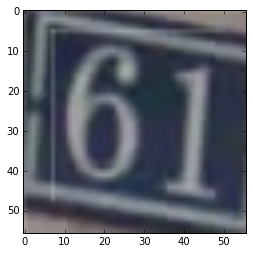

(56, 56, 4)
(56, 56, 3)
(1, 28, 28, 3)
27 173
-1.58978103791 2.32400307067


In [187]:
from scipy import ndimage
import scipy.misc as spm
import scipy.ndimage as spn

image_data = ndimage.imread('pic.png')

plt.imshow(image_data)
plt.show()
print(image_data.shape)

# for i in range(4):
#     plt.imshow(image_data[:, :, i])
#     plt.show()

image_data = image_data[:, :, :3]
print(image_data.shape)
image_data = image_data[::2, ::2, :]
image_data = np.reshape(image_data, [1, 28, 28, 3])
print(image_data.shape)

print(np.min(image_data), np.max(image_data))
image_data = (image_data - np.mean(image_data)) / np.std(image_data)
print(np.min(image_data), np.max(image_data))

# for i in range(3):
#     plt.imshow(image_data[0, :, :, i])
#     plt.show()

In [188]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
np.set_printoptions(linewidth=200)

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    

r = np.clip(np.array(result), -0.5, 0.5)
print(r)
np.reshape(r, [5, -1])

[  4.33620904e-03   5.00000000e-01   1.38585135e-01   4.86481674e-02   1.08459666e-01   3.30733657e-02   2.74634454e-02   5.51784411e-02   3.64251547e-02   4.04128619e-02   1.42410246e-03
   1.97055023e-02   2.35287920e-02   4.75052223e-02   2.16750558e-02   7.93201178e-02   2.64275521e-02   3.53516452e-02   1.82073954e-02   2.34586541e-02   2.01677959e-02   5.00000000e-01
   1.43451581e-03   1.99567759e-03   8.03962466e-04   2.55189603e-03   8.35680228e-04   1.34050054e-03   1.74479524e-03   1.07031816e-03   7.07745086e-04   1.31720316e-03   5.00000000e-01
   8.67867493e-04   7.93358253e-04   1.07636035e-03   7.82984367e-04   8.14524887e-04   5.73652738e-04   7.11823697e-04   6.56494463e-04   1.02144084e-03   9.39292309e-04   5.00000000e-01
   6.82123995e-04   1.77973823e-04   3.75766744e-04   2.61256529e-04   2.03420204e-04   4.71529260e-04   2.33484359e-04   9.05221328e-04   3.12456861e-04   3.69659043e-04   5.00000000e-01]


array([[  4.33620904e-03,   5.00000000e-01,   1.38585135e-01,   4.86481674e-02,   1.08459666e-01,   3.30733657e-02,   2.74634454e-02,   5.51784411e-02,   3.64251547e-02,   4.04128619e-02,
          1.42410246e-03],
       [  1.97055023e-02,   2.35287920e-02,   4.75052223e-02,   2.16750558e-02,   7.93201178e-02,   2.64275521e-02,   3.53516452e-02,   1.82073954e-02,   2.34586541e-02,   2.01677959e-02,
          5.00000000e-01],
       [  1.43451581e-03,   1.99567759e-03,   8.03962466e-04,   2.55189603e-03,   8.35680228e-04,   1.34050054e-03,   1.74479524e-03,   1.07031816e-03,   7.07745086e-04,   1.31720316e-03,
          5.00000000e-01],
       [  8.67867493e-04,   7.93358253e-04,   1.07636035e-03,   7.82984367e-04,   8.14524887e-04,   5.73652738e-04,   7.11823697e-04,   6.56494463e-04,   1.02144084e-03,   9.39292309e-04,
          5.00000000e-01],
       [  6.82123995e-04,   1.77973823e-04,   3.75766744e-04,   2.61256529e-04,   2.03420204e-04,   4.71529260e-04,   2.33484359e-04,   9.05

NameError: global name 'test_graphs' is not defined

In [194]:
with tf.Session(graph=graph) as sess:
    saver = tf.train.Saver(tf.all_variables())
    sess.run(tf.initialize_all_variables())
    
    # Here's where you're restoring the variables w and b.
    # Note that the graph is exactly as it was when the variables were
    # saved in a prior training run.
    
    checkpoint_path = os.path.join('save', 'model.ckpt')
    ckpt = tf.train.get_checkpoint_state('save')
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)
        
    predict_single_output = graph.get_tensor_by_name('predict_single_output:0')
    tf_predict_single_dataset = graph.get_tensor_by_name('tf_predict_single_dataset:0')
    feed_dict = {tf_predict_single_dataset : image_data}
    result = predict_single_output.eval(feed_dict=feed_dict)
                
    tf_train_dataset = graph.get_tensor_by_name('tf_train_dataset:0')
    tf_train_labels = [graph.get_tensor_by_name('tf_train_labels_%d:0' % i) for i in range(num_digits)]
    train_prediction = [graph.get_tensor_by_name('train_prediction_%d:0' % i) for i in range(num_digits)]
    valid_prediction = [graph.get_tensor_by_name('valid_prediction_%d:0' % i) for i in range(num_digits)]
    test_prediction = [graph.get_tensor_by_name('test_prediction_%d:0' % i) for i in range(num_digits)]
    optimizer = graph.get_tensor_by_name('optimizer:0')
    loss = graph.get_tensor_by_name('loss:0')
    learning_rate = graph.get_tensor_by_name('learning_rate:0')
            
    results = sess.run(test_prediction)
    

In [198]:
with tf.Session(graph=graph) as sess:
    saver = tf.train.Saver(tf.all_variables())
    sess.run(tf.initialize_all_variables())
    
    # Here's where you're restoring the variables w and b.
    # Note that the graph is exactly as it was when the variables were
    # saved in a prior training run.
    
    checkpoint_path = os.path.join('save', 'model.ckpt')
    ckpt = tf.train.get_checkpoint_state('save')
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)
        
    predict_single_output = graph.get_tensor_by_name('predict_single_output:0')
    tf_predict_single_dataset = graph.get_tensor_by_name('tf_predict_single_dataset:0')
    feed_dict = {tf_predict_single_dataset : image_data}
    result = predict_single_output.eval(feed_dict=feed_dict)

In [201]:
m = np.reshape(result, [5, -1])
print(np.apply_along_axis(np.argmax, 1, m))

[ 1 10 10 10 10]


In [204]:
r = np.array(results)
r.shape

for i in range(110, 110):
    img = test_dataset[i]
    plt.imshow(np.reshape(img, img.shape[:2]))
    plt.show()
    print(np.apply_along_axis(np.argmax, 1, test_labels[i]))
    n = r[:, i, :]
    print(np.apply_along_axis(np.argmax, 1, n))

In [210]:
image_data.shape

(1, 28, 28, 3)

In [217]:
img_height, img_width = 28, 28

def graph_play():
    graph = tf.Graph()
    
    with graph.as_default():

         # Create a single input tensor for use in the phone
        tf_predict_single_dataset = tf.placeholder(tf.float32, shape=(1,
                                                           img_height,
                                                           img_width,
                                                           3), name="input")
        
        conv = tf.reduce_mean(tf_predict_single_dataset, 3)
        print(conv.get_shape().as_list())
        # Shape it correctly
        conv = tf.reshape(conv, conv.get_shape().as_list() + [1], name='output')
        # Move the color range
        print(conv.get_shape().as_list())
        conv = tf.add(tf.div(conv, 255), -0.5, name='output')
        print(conv.get_shape().as_list())

    return graph

def run(graph):
    
    session = tf.Session(graph=graph);
    
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        
        tf_input = graph.get_tensor_by_name('input:0')
        
        tf_output = graph.get_tensor_by_name('output:0')
        
        feed_dict = {tf_input : image_data}        
        
        result = tf_output.eval(feed_dict=feed_dict)
        
    return result
        
result = run(graph_play())

[1, 28, 28]
[1, 28, 28, 1]
[1, 28, 28, 1]


In [218]:
result.shape

(55,)